In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras.utils as ku
import nltk
import glob, os, warnings
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GRU, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from numpy.random import seed
from keras.utils import np_utils

# --------------------------
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.random.set_seed(2)
seed(1)
# --------------------------

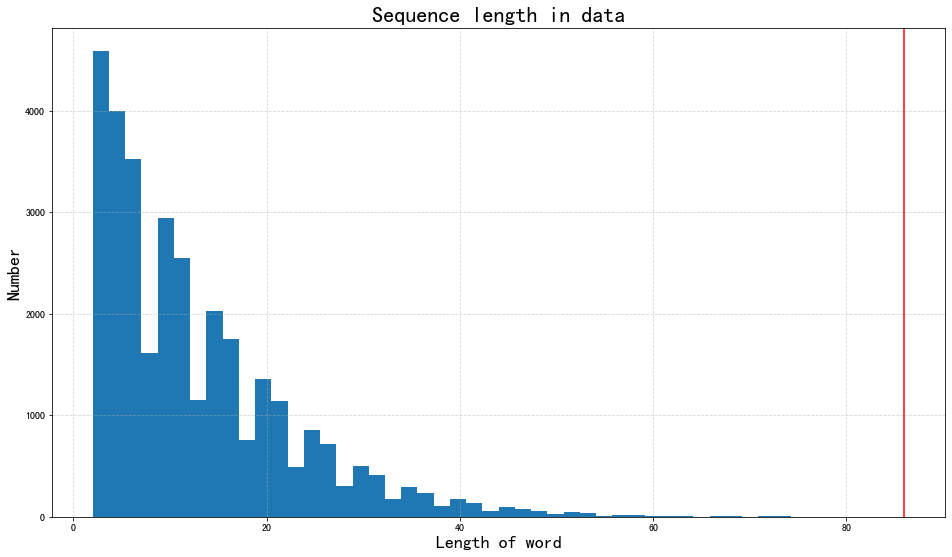

Length of source data: 2513
Number of total words: 11072
Max length of word in the text: 86
X.shape: (32283, 85)
y.shape: (32283, 11072)



In [91]:
source_data = []
for file in glob.glob('data_my_university_RU.txt'):
    f = open(file,'r')
    txt = f.read().replace('\n', ' ')
    sent_text = nltk.sent_tokenize(txt, language='russian')
    
    for k in sent_text :
        source_data.append(k)
        
tokenizer = Tokenizer()
tokenizer.fit_on_texts(source_data)


input_sequences = []
for sent in source_data:
    token_list = tokenizer.texts_to_sequences([sent])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

num_total_words = len(tokenizer.word_index) + 1
max_word_length = max([len(x) for x in input_sequences])

plt.figure(figsize=(16, 9))
plt.hist([len(x) for x in input_sequences], bins=50)
plt.title("Sequence length in data", size=22)
plt.xlabel('Length of word', size=18)
plt.ylabel('Number', size=18)
plt.grid(linestyle='--', alpha=0.5)
plt.axvline(max_word_length, c="r")
plt.show()

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_word_length, padding='pre'))
X = input_sequences[:,:-1]
y = np_utils.to_categorical(input_sequences[:,-1], num_classes=num_total_words)
np.save("X.npy", X)

print(f'Length of source data: {len(source_data)}\n'
      f'Number of total words: {num_total_words}\n'
      f'Max length of word in the text: {max_word_length}\n'
      f'X.shape: {X.shape}\n'
      f'y.shape: {y.shape}\n')

In [92]:
def sequence_n_grams(corpus):
    # tokenization
    tokenizer.fit_on_texts(corpus)
    num_total_words = len(tokenizer.word_index) + 1
    
    # convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, num_total_words

inp_sequences, num_total_words = sequence_n_grams(source_data)
inp_sequences[:10]

[[1280, 3492],
 [1280, 3492, 170],
 [1280, 3492, 170, 1281],
 [1280, 3492, 170, 1281, 9],
 [1280, 3492, 170, 1281, 9, 742],
 [1280, 3492, 170, 1281, 9, 742, 1280],
 [1280, 3492, 170, 1281, 9, 742, 1280, 170],
 [1280, 3492, 170, 1281, 9, 742, 1280, 170, 1281],
 [1280, 3492, 170, 1281, 9, 742, 1280, 170, 1281, 1942],
 [1280, 3492, 170, 1281, 9, 742, 1280, 170, 1281, 1942, 3]]

In [93]:
def generate_padded_sequences(input_sequences):
    max_word_length = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_word_length, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = np_utils.to_categorical(label, num_classes=num_total_words)
    return predictors, label, max_word_length

predictors, label, max_word_length = generate_padded_sequences(input_sequences)

In [94]:
predictors.shape

(32283, 85)

In [95]:
label.shape

(32283, 11072)

In [96]:
def create_model(max_word_length, num_total_words):
    input_len = max_word_length - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(num_total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(GRU(128))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(num_total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model(max_word_length, num_total_words)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 85, 10)            110720    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               53760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11072)             1428288   
Total params: 1,592,768
Trainable params: 1,592,768
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(X, y, batch_size=64, epochs=50, verbose=True)
model.save('res_gen.h5')

Epoch 1/50


2022-11-19 17:12:20.882576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-19 17:12:21.040928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-19 17:12:21.292398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


505/505 [==============================] - 37s 70ms/step - loss: 8.5422 - accuracy: 0.0343
Epoch 2/50
505/505 [==============================] - 35s 69ms/step - loss: 7.8650 - accuracy: 0.0359
Epoch 3/50
505/505 [==============================] - 32s 64ms/step - loss: 7.8055 - accuracy: 0.0351
Epoch 4/50
505/505 [==============================] - 33s 66ms/step - loss: 7.6866 - accuracy: 0.0366
Epoch 5/50
505/505 [==============================] - 31s 62ms/step - loss: 7.4692 - accuracy: 0.0393
Epoch 6/50
505/505 [==============================] - 30s 60ms/step - loss: 7.2506 - accuracy: 0.0389
Epoch 7/50
505/505 [==============================] - 32s 64ms/step - loss: 6.9803 - accuracy: 0.0381
Epoch 8/50
505/505 [==============================] - 35s 68ms/step - loss: 6.6564 - accuracy: 0.0433
Epoch 9/50
505/505 [==============================] - 33s 66ms/step - loss: 6.3707 - accuracy: 0.0426
Epoch 10/50
505/505 [==============================] - 34s 68ms/step - loss: 6.0623 - accurac

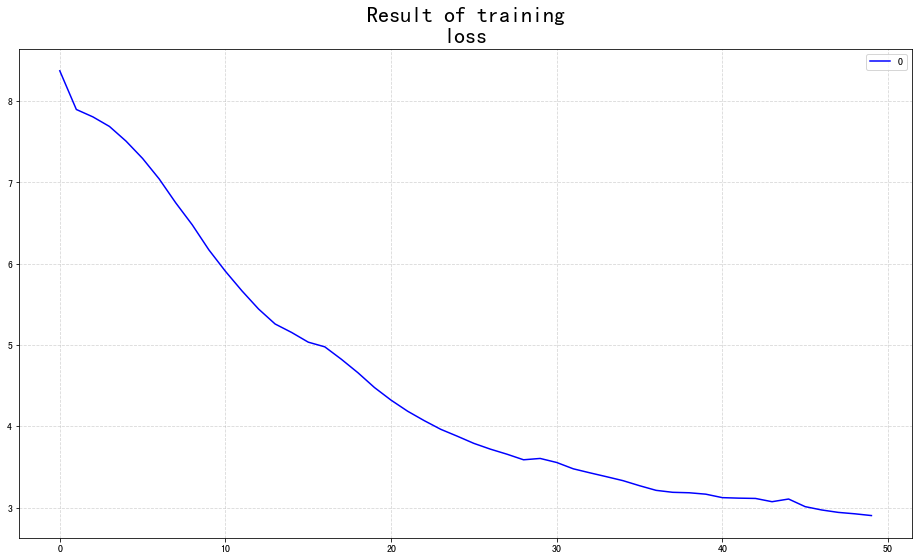

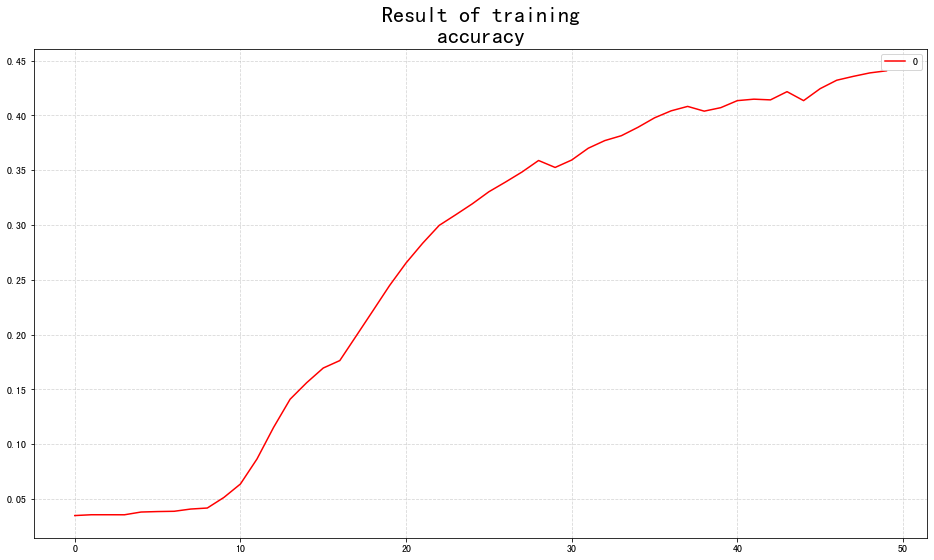

In [109]:
pd.DataFrame(history.history['loss']).plot(figsize=(16, 9), c='b')
plt.grid(linestyle='--', alpha=0.5)
plt.title('Result of training\nloss', size=22)
plt.show()

pd.DataFrame(history.history['accuracy']).plot(figsize=(16, 9), c='r')
plt.grid(linestyle='--', alpha=0.5)
plt.title('Result of training\naccuracy', size=22)
plt.show()

In [115]:
def generate_text(text_head, num_gen_word, model, max_word_length):
    for _ in range(num_gen_word):
        token_list = tokenizer.texts_to_sequences([text_head])[0]
        token_list = pad_sequences([token_list], maxlen=max_word_length-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        text_head += " "+output_word
    return text_head

In [133]:
generate_text("Ты зачем", 3, model, 30)

'Ты зачем понять не этот'

In [132]:
generate_text("Я часто", 8, model, 30)

'Я часто взглянул в городе утра и в поле ночь'

In [138]:
generate_text("В декабре", 5, model, 30)

'В декабре у я испуг тревожное предчувствие'

In [140]:
generate_text("Мне трудно понять", 10, model, 30)

'Мне трудно понять не меньше это печке на стуле и в них ночь'

In [145]:
generate_text("Посоветовался с", 17, model, 30)

'Посоветовался с тобой в углу этих я паяц и в тот ломятся дел в сердце и слушать смотрели помочь'